In [281]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


# Booking.  Предсказание рейтинга отеля.

In [282]:
# импорт библиотек
import pandas as pd
from sklearn.feature_selection import chi2 # хи-квадрат
from sklearn.feature_selection import f_classif # anova
from sklearn.model_selection import train_test_split  # Загружаем специальный инструмент для разбивки
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
from sklearn import preprocessing # для процесса нормализации
import category_encoders as ce # импортируем библиотеку для работы с кодировщиками
import matplotlib.pyplot as plt 
import seaborn as sns

## Загрузка и анализ данных

In [283]:
DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн# Загружаем данные из соревнования

In [284]:
# анализ данных для обучения
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [285]:
df_train.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060


In [286]:
# анализ данных для оценки качества
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [287]:
df_test.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,4.888644


## Объединение данных для обучения модели и проверки ее качества в один датасет

In [288]:
# для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями
data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

## Создание новых признаков

### Признак "Население города, где расположен отель"

In [289]:
# Создаем новый датасет с информацией об отеле
# Признаки, характеризующие отель, а не отзыв
hotel_cols = ['hotel_name', 'hotel_address', 'lat', 'lng', 'average_score', 'total_number_of_reviews', 'additional_number_of_scoring']
hotels = data[hotel_cols].drop_duplicates().reset_index(drop=True)
hotels['hotel_id'] = hotels.index

In [290]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1494 entries, 0 to 1493
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   hotel_name                    1494 non-null   object 
 1   hotel_address                 1494 non-null   object 
 2   lat                           1477 non-null   float64
 3   lng                           1477 non-null   float64
 4   average_score                 1494 non-null   float64
 5   total_number_of_reviews       1494 non-null   int64  
 6   additional_number_of_scoring  1494 non-null   int64  
 7   hotel_id                      1494 non-null   int64  
dtypes: float64(3), int64(3), object(2)
memory usage: 93.5+ KB


In [291]:
# Добавляем к основному датасету ID отеля, убираем признаки, относящиеся к отелю, из основного дата-сета
data = data.merge(hotels, on=hotel_cols, how='left')
data = data.drop(hotel_cols, axis=1)

In [292]:
# Выделяем страну, город и почтовый индекс из адреса отеля
# Добавляем население города (https://en.wikipedia.org/wiki/List_of_European_cities_by_population_within_city_limits)
сity_population = {'Paris': 2165423, 'London': 9002488, 'Milan': 1374582, 'Vienna': 1931830, 'Barcelona': 1636732, 'Amsterdam': 821752}
hotels['city'] = hotels.hotel_address.apply(lambda x: 'London' if x.endswith('United Kingdom') else x.split()[-2])
hotels['сity_population'] = hotels.apply(lambda x: сity_population[x['city']], axis=1)

# Нормализация признака
hotels['сity_population']=hotels['сity_population']/hotels['сity_population'].max()
hotels['сity_population'].value_counts()
hotels.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1494 entries, 0 to 1493
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   hotel_name                    1494 non-null   object 
 1   hotel_address                 1494 non-null   object 
 2   lat                           1477 non-null   float64
 3   lng                           1477 non-null   float64
 4   average_score                 1494 non-null   float64
 5   total_number_of_reviews       1494 non-null   int64  
 6   additional_number_of_scoring  1494 non-null   int64  
 7   hotel_id                      1494 non-null   int64  
 8   city                          1494 non-null   object 
 9   сity_population               1494 non-null   float64
dtypes: float64(4), int64(3), object(3)
memory usage: 116.8+ KB


In [293]:
data_new=data.copy()
data_new=data_new.merge(hotels, on=['hotel_id'], how='left')
data_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 21 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   review_date                                 515738 non-null  object 
 1   reviewer_nationality                        515738 non-null  object 
 2   negative_review                             515738 non-null  object 
 3   review_total_negative_word_counts           515738 non-null  int64  
 4   positive_review                             515738 non-null  object 
 5   review_total_positive_word_counts           515738 non-null  int64  
 6   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 7   tags                                        515738 non-null  object 
 8   days_since_review                           515738 non-null  object 
 9   sample                                      515738 non-null  int64  
 

In [294]:
data_new.drop(['lat', 'lng', 'hotel_address'], axis = 1, inplace=True)

### Создание признака "Сезон проживания в отеле"

In [295]:
# перевод данных столбца review_date в формат Datatime
data_new['review_date'] = pd.to_datetime(data_new['review_date'], dayfirst=False, yearfirst=False)

# большинство отзывов пишутся сразу после пребывания в отеле, поэтому по дате отзыва можно определить сезон
# когда автор отдыха пребывал в отеле
def get_season(date):
    """ функция преобразования даты написания отзыва в строку "Сезон" """
    if date in [12, 1, 2]:
        # зима
        return 1
    if date in [3, 4, 5]:
        # весна
        return 2
    if date in [6, 7, 8]:
        # лето
        return 3
    if date in [9, 10, 11]:
        # осень
        return 4
       
# преобразование строки 'review_dateт' и запись  в новый столбец 'season'
data_new['season'] = data_new['review_date'].dt.month.apply(get_season)
    

### Создание признака "Возраст отзыва в годах"

In [296]:
data_new['year'] = 2022- data_new['review_date'].dt.year
# Нормализация признака
data_new['year']=1/data_new['year']
data_new['year'].value_counts()

0.166667    264403
0.200000    156808
0.142857     94527
Name: year, dtype: int64

### Создание признака "Число дней проживания в отеле"

In [297]:
# определение числа дней пребывания в отеле
def get_n_days(tag):
    """ функция определения числа дней пребывания в отеле"""
    # удаление квадратных скобок и разделение строки тегов на отдельные теги
    spis_tag_i=tag[1:]
    spis_tag_i=tag[:-1]
    arg=spis_tag_i.lower().split(',') 
    num=0
    for j in range(0,len(arg)):
        # удаление пробелов и ковычек
        arg[j]=arg[j].strip()
        arg[j]=arg[j][1:len(arg[j])-1]
        spis_arg=arg[j].split(' ')
        # поиск числового значения, стоящего за словом Stayed
        
        if 'stayed' in spis_arg:
            for x in spis_arg: 
                if x.isdigit():
                    num=x
              
    return num

data_new['n_days']=data_new['tags'].apply(get_n_days)
data_new['n_days'] = data_new['n_days'].astype('int') 


In [298]:
print(data_new.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 21 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   review_date                                 515738 non-null  datetime64[ns]
 1   reviewer_nationality                        515738 non-null  object        
 2   negative_review                             515738 non-null  object        
 3   review_total_negative_word_counts           515738 non-null  int64         
 4   positive_review                             515738 non-null  object        
 5   review_total_positive_word_counts           515738 non-null  int64         
 6   total_number_of_reviews_reviewer_has_given  515738 non-null  int64         
 7   tags                                        515738 non-null  object        
 8   days_since_review                           515738 non-null  object       

### Создание признаков "Положительный/отрицательный индекс отзыва"

In [299]:
# Анализ слов в отзывах
# список слов в негативных отзывах, которые говорят об отсутствии негатива
no_neg_list = ['everything was perfect', 'absolutely nothing','nothing',  'all good', 'nothing really', 'no complaints', 'nil', 'nothing at all', 'nothing to dislike', 'liked everything',
              'can t think of anything',  'nothing to dislike', 'no negative', 'none','everything was great', 'nothing to complain about']
# список слов в положительных отзывах, которые говорят об отсутствии положительного впечатления об отеле
no_pos_list = ['no positive', 'nothing']

def dop_neg_point(data):
    '''функция опрееления дополнительных положительных очков отелю'''
    data=data.lower()
    if 'no positive' in data:
        return 1
    for i in no_pos_list:
        if i in data:
            return 1
    return 0
    
def dop_pos_point(data):
    '''функция опрееления дополнительных отрицательных очков отелю'''
    data=data.lower()
    if 'no negative' in data:
        return 1
    for i in no_neg_list:
        if i in data:
            return 1
    
    return 0
    
def neg_point(data):
    '''функция опрееления отрицательных очков отелю исходя из данных отирцательных отзывов'''
    data=data.lower()
    if 'no negative' in data:
        return 0
    for i in no_neg_list:
        if i in data:
            return 0
    return 1    

def pos_point(data):
    '''функция опрееления  положительных очков отелю исходя из данных положительных отзывов'''
    data=data.lower()
    if 'no positive' in data:
        return 0
    for i in no_pos_list:
        if i in data:
            return 0
    return 1   
    
data_new['neg_point'] = data_new['negative_review'].apply(neg_point)
data_new['pos_point'] = data_new['positive_review'].apply(pos_point)
data_new['neg_dop_point'] = data_new['positive_review'].apply(dop_neg_point)
data_new['pos_dop_point'] = data_new['negative_review'].apply(dop_pos_point)
#определение общего числа отрицательных очков отелю
data_new['neg_point']=data_new['neg_point']+data_new['neg_dop_point']
#определение общего числа положительных очков отелю
data_new['pos_point'] = data_new['pos_point']+data_new['pos_dop_point']
data_new=data_new.drop(['neg_dop_point', 'pos_dop_point'], axis=1)


In [300]:
data_new['pos_point'].value_counts()


1    305579
2    170797
0     39362
Name: pos_point, dtype: int64

### Создание признака "Тип проживания - отдых"

In [301]:
# Добавление признака того, что тип проживания в отеле - отдых (не бизнес поездка)
# Разбиваем отзывы клиентов в зависимости от типа проживания: отдых и бизнес
def rest_point(tag):
    """ функция обнаружения информации об отдыхе из тегов"""
    # удаление квадратных скобок и разделение строки тегов на отдельные теги
    
    spis_rest=['leisure', 'children', 'child', 'couple', 'solo traveler']
    spis_tag_i=tag[1:]
    spis_tag_i=tag[:-1]
    arg=spis_tag_i.lower().split(',') 
    
    for j in range(0,len(arg)):
        # удаление пробелов и ковычек
        arg[j]=arg[j].strip()
        arg[j]=arg[j][1:len(arg[j])-1]
        spis_arg=arg[j].split(' ')
        # поиск числового значения, стоящего за словом Stayed
        if 'stayed' in spis_arg:
            for x in spis_arg: 
                if x.isdigit():
                    if int(x)>5:
                        return 1
        for i in spis_rest:
            if i in spis_arg:
                return 1    
    return 0
   
data_new['rest']=data_new['tags'].apply(rest_point)

data_new['rest'].value_counts()

1    447466
0     68272
Name: rest, dtype: int64

In [302]:
print(data_new.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 24 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   review_date                                 515738 non-null  datetime64[ns]
 1   reviewer_nationality                        515738 non-null  object        
 2   negative_review                             515738 non-null  object        
 3   review_total_negative_word_counts           515738 non-null  int64         
 4   positive_review                             515738 non-null  object        
 5   review_total_positive_word_counts           515738 non-null  int64         
 6   total_number_of_reviews_reviewer_has_given  515738 non-null  int64         
 7   tags                                        515738 non-null  object        
 8   days_since_review                           515738 non-null  object       

### Создание признака "Национальность автора отзыва"

In [303]:
# Анализ национальности автора отзыва

best_countries= data_new['reviewer_nationality'].value_counts()
spis_country= list()
for i in range(0,10):
    spis_country.append(best_countries.index[i]);

data_new['reviewer_nationality']=data_new['reviewer_nationality'].apply(lambda x: x if (x in spis_country) else 'other')
print(data_new['reviewer_nationality'].value_counts())



 United Kingdom               245246
other                         146071
 United States of America      35437
 Australia                     21686
 Ireland                       14827
 United Arab Emirates          10235
 Saudi Arabia                   8951
 Netherlands                    8772
 Switzerland                    8678
 Germany                        7941
 Canada                         7894
Name: reviewer_nationality, dtype: int64


In [304]:
# Кодировка признака
encoder = ce.OneHotEncoder(cols=['reviewer_nationality']) # указываем столбец для кодирования
data_dop = encoder.fit_transform(data_new['reviewer_nationality'])
data_new = pd.concat([data_new, data_dop], axis=1)
data_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 35 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   review_date                                 515738 non-null  datetime64[ns]
 1   reviewer_nationality                        515738 non-null  object        
 2   negative_review                             515738 non-null  object        
 3   review_total_negative_word_counts           515738 non-null  int64         
 4   positive_review                             515738 non-null  object        
 5   review_total_positive_word_counts           515738 non-null  int64         
 6   total_number_of_reviews_reviewer_has_given  515738 non-null  int64         
 7   tags                                        515738 non-null  object        
 8   days_since_review                           515738 non-null  object       

## Очистка данных 

In [305]:
# Уничтожение всех категориальных признаков
object_columns = [s for s in data_new.columns if data_new[s].dtypes == 'object']
data_new.drop(object_columns, axis = 1, inplace=True)
data_new.drop('review_date', axis = 1, inplace=True)
data_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 27 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   review_total_negative_word_counts           515738 non-null  int64  
 1   review_total_positive_word_counts           515738 non-null  int64  
 2   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 3   sample                                      515738 non-null  int64  
 4   reviewer_score                              515738 non-null  float64
 5   hotel_id                                    515738 non-null  int64  
 6   average_score                               515738 non-null  float64
 7   total_number_of_reviews                     515738 non-null  int64  
 8   additional_number_of_scoring                515738 non-null  int64  
 9   сity_population                             515738 non-null  float64
 

<AxesSubplot:>

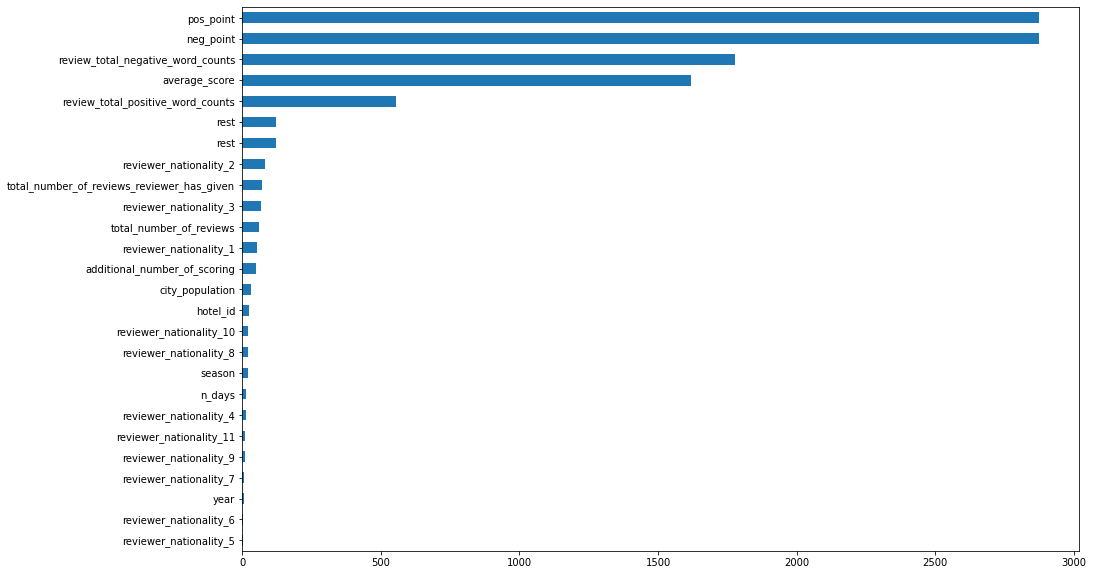

In [306]:
# числовые  признаки

num_cols = ['total_number_of_reviews',
            'review_total_negative_word_counts', 
            'review_total_positive_word_counts', 
            'total_number_of_reviews_reviewer_has_given',
            'additional_number_of_scoring', 
            'season',
            'hotel_id',
            'n_days',
            'pos_point',
            'neg_point',
            'rest',
            'сity_population',
            'rest',
            'reviewer_nationality_1', 
            'reviewer_nationality_2',
            'reviewer_nationality_3',
            'reviewer_nationality_4',
            'reviewer_nationality_5',
            'reviewer_nationality_6',
            'reviewer_nationality_7',
            'reviewer_nationality_8',
            'reviewer_nationality_9',
            'reviewer_nationality_10',
            'reviewer_nationality_11', 
            'average_score',
            'year'
            ]   
            

# Для оценки значимости непрерывных переменных будем использовать функцию f_classif из библиотеки sklearn.
# В основе метода оценки значимости переменных лежит анализ (ANOVA).
# В качестве меры значимости будем использовать значение f-статистики - чем значение статистики выше, тем меньше 
# вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей модели.

y = data_new['reviewer_score'] 
X = data_new.drop(['reviewer_score'], axis = 1)  

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')



<AxesSubplot:>

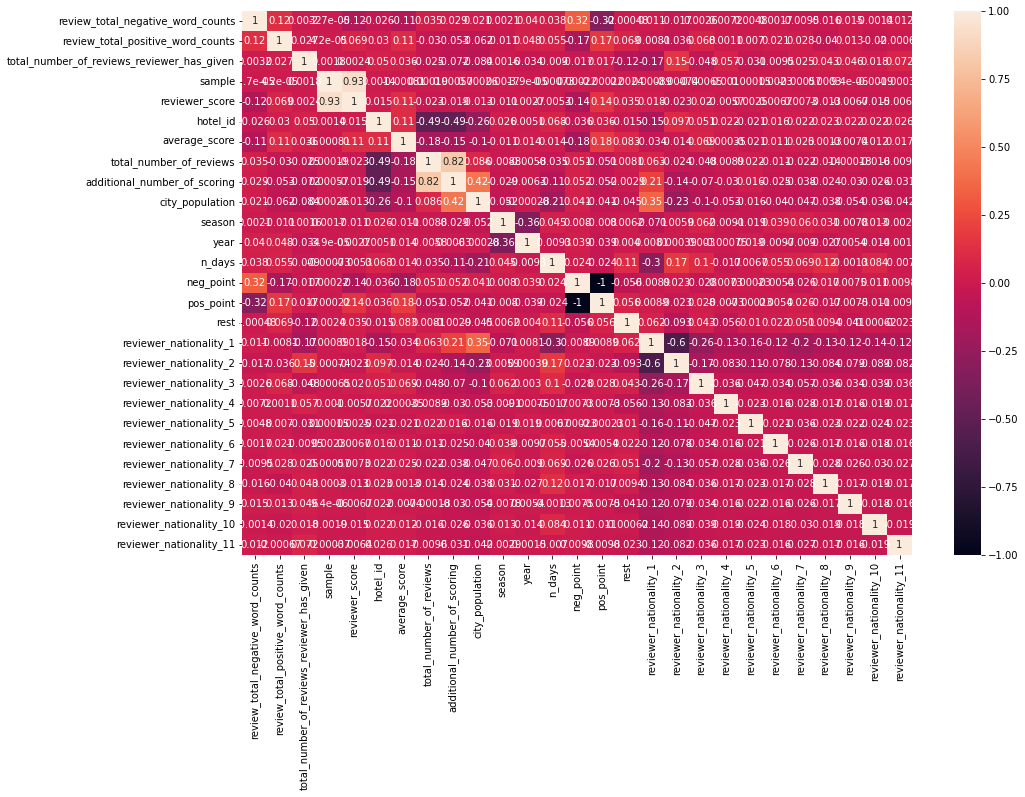

In [307]:
# Проверка на мультикорреляцию
# чтобы исключить мультиколлениарность удалим признаки, сильно коррелирующий с другим признаком
plt.rcParams['figure.figsize'] = (15,10)

sns.heatmap(data_new.corr(), annot=True)

## Подготовка данных для модели

In [308]:
# Теперь выделим тестовую часть
train_data = data_new.query('sample == 1').drop(['sample'], axis=1)
test_data = data_new.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values
X = train_data.drop(['reviewer_score'], axis=1)
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(X_train.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 290102 entries, 151787 to 250893
Data columns (total 25 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   review_total_negative_word_counts           290102 non-null  int64  
 1   review_total_positive_word_counts           290102 non-null  int64  
 2   total_number_of_reviews_reviewer_has_given  290102 non-null  int64  
 3   hotel_id                                    290102 non-null  int64  
 4   average_score                               290102 non-null  float64
 5   total_number_of_reviews                     290102 non-null  int64  
 6   additional_number_of_scoring                290102 non-null  int64  
 7   сity_population                             290102 non-null  float64
 8   season                                      290102 non-null  int64  
 9   year                                        290102 non-null  floa

In [309]:
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  


In [310]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.133131163445015


<AxesSubplot:>

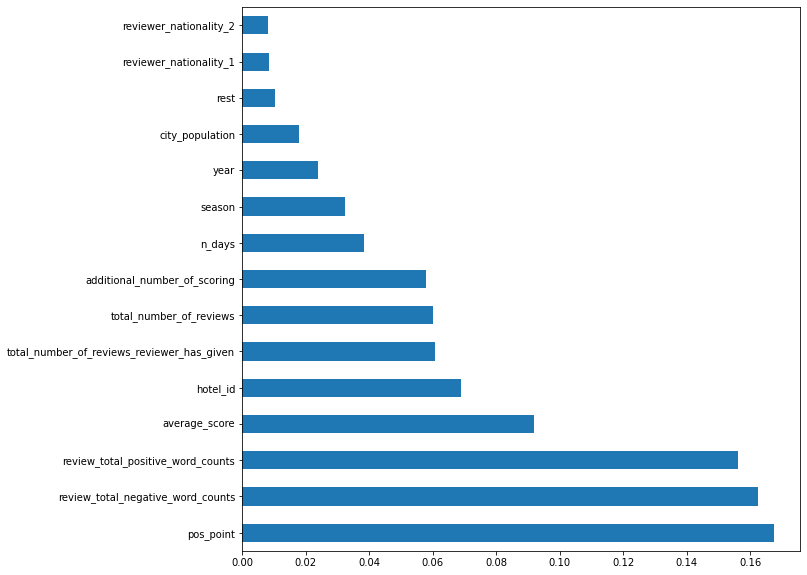

In [311]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [312]:
test_data = test_data.drop(['reviewer_score'], axis=1)
predict_submission = regr.predict(test_data)

In [313]:
predict_submission


array([8.735, 7.231, 8.144, ..., 8.292, 9.55 , 7.264])

In [315]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('Voronina_predict.csv', index = False)
sample_submission.head(10)

,reviewer_score,id
0,8.735,488440
1,7.231,274649
2,8.144,374688
3,9.312,404352
4,9.354,451596
5,8.240,302161
6,8.510,317079
7,7.453,13963
8,8.529,159785
9,7.277,195089
